In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/PINN/train_data.csv')
test_df = pd.read_csv('/content/drive/MyDrive/PINN/test_data.csv')

In [4]:
assert train_df.columns.all() == test_df.columns.all()

In [5]:
train_df = train_df[['event_id','mission_id', 't_j2k_inc', 'c_j2k_inc', 't_j2k_sma', 'c_j2k_sma', 'time_to_tca', 'relative_position_n', 'relative_position_r', 'relative_position_t', 'relative_velocity_n', 'relative_velocity_r', 'relative_velocity_t', 'c_object_type', 'risk', 't_j2k_ecc', 'c_j2k_ecc']]
test_df = test_df [['event_id','mission_id', 't_j2k_inc', 'c_j2k_inc', 't_j2k_sma', 'c_j2k_sma', 'time_to_tca', 'relative_position_n', 'relative_position_r', 'relative_position_t', 'relative_velocity_n', 'relative_velocity_r', 'relative_velocity_t', 'c_object_type', 'risk', 't_j2k_ecc', 'c_j2k_ecc']]
train_df= train_df.dropna()
test_df = test_df.dropna()


In [6]:
train_df = train_df.groupby("event_id", as_index=False).tail(1)
test_df = test_df.groupby("event_id", as_index=False).tail(1)
train_df.head()

,event_id,mission_id,t_j2k_inc,c_j2k_inc,t_j2k_sma,c_j2k_sma,time_to_tca,relative_position_n,relative_position_r,relative_position_t,relative_velocity_n,relative_velocity_r,relative_velocity_t,c_object_type,risk,t_j2k_ecc,c_j2k_ecc
4,0,5,97.806426,74.045736,6996.920446,7006.626646,0.257806,-13288.0,478.7,5811.1,-5525.9,-7.0,-12637.0,UNKNOWN,-10.391260,0.003996,0.003144
8,1,5,97.767002,82.431524,7001.561205,6880.588349,3.570013,6638.2,-82.0,-26067.0,-3328.2,56.8,-847.8,DEBRIS,-9.248105,0.001028,0.017491
28,2,2,98.523055,69.718579,7158.408492,7168.395415,0.401947,17968.9,-717.9,-5159.0,-3957.2,14.4,-13791.4,UNKNOWN,-30.000000,0.000863,0.001298
49,3,19,98.151377,70.871582,7083.606348,7070.083052,0.283061,21639.4,51.8,10055.9,5718.9,-39.6,-12310.9,DEBRIS,-30.000000,0.002115,0.004567
58,4,19,98.355051,81.142918,7082.424287,7076.199819,0.273166,18682.4,187.1,-13552.1,-7101.8,19.3,-9788.5,DEBRIS,-27.650917,0.003943,0.004761


In [7]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

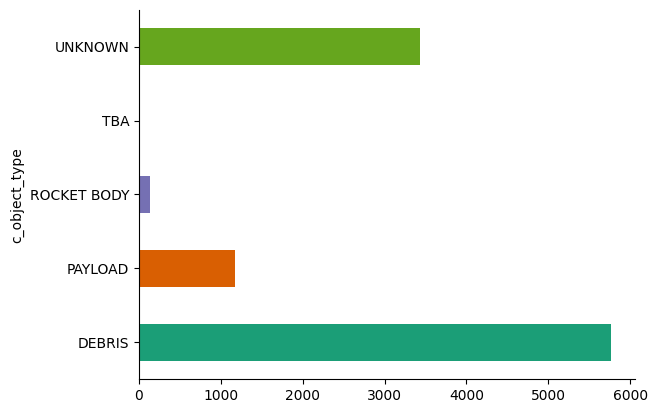

In [8]:
# @title c_object_type

from matplotlib import pyplot as plt
import seaborn as sns
train_df.groupby('c_object_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [9]:
#convert Inclination from degrees to radians
def to_tensor(series):
    arr = series.values                     # <-- .values happens here
    if arr.max() > math.pi:  # likely in degrees
        arr = arr * math.pi / 180.0
    return torch.tensor(arr, dtype=torch.float32)

def normalize(tensor, mean=None, std=None):
    """
    Normalize tensor to mean=0, std=1.
    If mean/std are provided, use them (for test data).
    """
    if mean is None:
        mean = tensor.mean()
    if std is None:
        std = tensor.std()
    return (tensor - mean) / std, mean, std

# --- Prepare Tensors ---
# Training set
a_train_raw = torch.tensor(train_df['c_j2k_sma'].values, dtype=torch.float32)
e_train_raw = torch.tensor(train_df['c_j2k_ecc'].values, dtype=torch.float32)
I_train_raw = to_tensor(train_df['c_j2k_inc'])
P_train_raw = torch.tensor(train_df['risk'].values, dtype=torch.float32)

# Normalize inputs and output, and store means/stds for de-normalization
a_train, a_mean, a_std = normalize(a_train_raw)
e_train, e_mean, e_std = normalize(e_train_raw)
I_train, I_mean, I_std = normalize(I_train_raw)
P_train, P_mean, P_std = normalize(P_train_raw)

# Validation set (normalize with TRAIN means/stds!)
a_val_raw = torch.tensor(val_df['c_j2k_sma'].values, dtype=torch.float32)
e_val_raw = torch.tensor(val_df['c_j2k_ecc'].values, dtype=torch.float32)
I_val_raw = to_tensor(val_df['c_j2k_inc'])
P_val_raw = torch.tensor(val_df['risk'].values, dtype=torch.float32)

a_val = (a_val_raw - a_mean) / a_std
e_val = (e_val_raw - e_mean) / e_std
I_val = (I_val_raw - I_mean) / I_std
P_val = (P_val_raw - P_mean) / P_std

# Test set (normalize with TRAIN means/stds!)
a_test_raw = torch.tensor(test_df['c_j2k_sma'].values, dtype=torch.float32)
e_test_raw = torch.tensor(test_df['c_j2k_ecc'].values, dtype=torch.float32)
I_test_raw = to_tensor(test_df['c_j2k_inc'])
P_test_raw = torch.tensor(test_df['risk'].values, dtype=torch.float32)

a_test = (a_test_raw - a_mean) / a_std
e_test = (e_test_raw - e_mean) / e_std
I_test = (I_test_raw - I_mean) / I_std
P_test = (P_test_raw - P_mean) / P_std

print("Any NaNs in training data?", torch.isnan(a_train).any().item(),
      torch.isnan(e_train).any().item(),
      torch.isnan(I_train).any().item(),
      torch.isnan(P_train).any().item())


Any NaNs in training data? False False False False


In [10]:
train_dataset = TensorDataset(a_train, e_train, I_train, P_train)

# Create a DataLoader that splits into 32 batches
batch_size = len(train_dataset) // 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 2. Define Model
# --------------------
class PINN_P(nn.Module):
    def __init__(self, w=128, d=6):
        super().__init__()
        layers = []
        dims = [3] + [w]*d + [1]
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            if i < len(dims)-2:
                layers.append(nn.Tanh())
        self.net = nn.Sequential(*layers)

    def forward(self, a, e, I):
        x = torch.stack([a, e, I], dim=-1)
        return self.net(x).squeeze(-1)

# --------------------
# 3. Physics Equations
# --------------------
def U_from_aeI(a, e, I, eps=1e-8):
    """Calculates total relative velocity U from Equation (2)."""
    sqrt_inner = torch.clamp(a * (1 - e**2), min=0.0)
    term = 3 - 1.0 / torch.clamp(a, min=eps) - 2 * torch.sqrt(sqrt_inner) * torch.cos(I)
    term = torch.clamp(term, min=0.0)
    return torch.sqrt(term)

def Ux_from_ae(a, e, eps=1e-8):
    """Calculates the x-component of relative velocity Ux."""
    term = 2 - 1.0 / torch.clamp(a, min=eps) - a * (1 - e**2)
    term = torch.clamp(term, min=0.0)
    return torch.sqrt(term)

def physics_residual(P_pred, a, e, I, eps=1e-8):
    """
    Calculates the residual of the physics equation (P_pred - P_physics).
    IMPORTANT: This function must be called with DE-NORMALIZED data.
    """
    U_calc = U_from_aeI(a, e, I, eps)
    Ux_calc = Ux_from_ae(a, e, eps)

    denom = (2 * math.pi**2) * torch.clamp(a, min=eps)**1.5 * (Ux_calc + eps) * (torch.abs(torch.sin(I)) + eps)
    P_phys = U_calc / denom

    return P_pred - P_phys

# --------------------
# 4. Train
# --------------------
model = PINN_P()
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

# Adjusted lambda values for better initial training
lambda_phys, lambda_data = 1.0 , 1.0

n_epochs = 5000
start = time.time()
loss_history = []
phys_history = []
data_history = []

for epoch in range(n_epochs):
    model.train()

    epoch_phys = 0.0
    epoch_data = 0.0
    n_batches = 0

    for a_b, e_b, I_b, P_b in train_loader:
        # --- 1. Forward on NORMALIZED batch
        P_pred_norm = model(a_b, e_b, I_b)

        # --- 2. Data loss (normalized)
        loss_data = torch.mean((P_pred_norm - P_b)**2)

        # --- 3. De-normalize batch
        a_b_denorm = a_b * a_std + a_mean
        e_b_denorm = e_b * e_std + e_mean
        I_b_denorm = I_b * I_std + I_mean
        P_pred_denorm = P_pred_norm * P_std + P_mean

        # --- 4. Physics loss on DE-NORMALIZED batch
        r_phys = physics_residual(P_pred_denorm, a_b_denorm, e_b_denorm, I_b_denorm)
        loss_phys = torch.mean(r_phys**2)

        # --- 5. Combined loss
        loss = lambda_phys * loss_phys + lambda_data * loss_data

        opt.zero_grad()
        loss.backward()
        opt.step()

        # Track batch losses
        epoch_phys += loss_phys.item()
        epoch_data += loss_data.item()
        n_batches += 1

    # Average losses per epoch
    epoch_phys /= n_batches
    epoch_data /= n_batches
    loss_history.append(epoch_phys + epoch_data)
    phys_history.append(epoch_phys)
    data_history.append(epoch_data)


    # --- Validation (unchanged) ---
    model.eval()
    with torch.no_grad():
        P_val_pred_norm = model(a_val, e_val, I_val)
        val_data_loss = torch.mean((P_val_pred_norm - P_val)**2)

        a_val_denorm = a_val * a_std + a_mean
        e_val_denorm = e_val * e_std + e_mean
        I_val_denorm = I_val * I_std + I_mean
        P_val_pred_denorm = P_val_pred_norm * P_std + P_mean

        r_phys_val = physics_residual(P_val_pred_denorm, a_val_denorm, e_val_denorm, I_val_denorm)
        val_phys_loss = torch.mean(r_phys_val**2)

        val_loss = lambda_phys * val_phys_loss + lambda_data * val_data_loss

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: "
              f"train_loss={epoch_phys+epoch_data:.6f}, val_loss={val_loss.item():.6f}, "
              f"train_phys={epoch_phys:.6f}, val_phys={val_phys_loss.item():.6f}, "
              f"train_data={epoch_data:.6f}, val_data={val_data_loss.item():.6f}")
# --- End timing ---
end = time.time()
print(f"Training time for {n_epochs} epochs ({len(train_loader)} batches): {end - start:.2f} seconds")

# --------------------
# 5. Evaluate on Test Set
# --------------------
model.eval()
with torch.no_grad():
    P_test_pred_norm = model(a_test, e_test, I_test)

    # Calculate test data loss on normalized values
    test_data_error = torch.mean((P_test_pred_norm - P_test)**2).item()
    print(f"\nTest Data MSE (normalized): {test_data_error:.6f}")

    # De-normalize test data for physics residual calculation
    a_test_denorm = a_test * a_std + a_mean
    e_test_denorm = e_test * e_std + e_mean
    I_test_denorm = I_test * I_std + I_mean
    P_test_pred_denorm = P_test_pred_norm * P_std + P_mean
    P_test_true_denorm = P_test * P_std + P_mean

    r_phys_test = physics_residual(P_test_pred_denorm, a_test_denorm, e_test_denorm, I_test_denorm)
    test_phys_error = torch.mean(r_phys_test**2).item()
    print(f"Test Physics Residual MSE (de-normalized): {test_phys_error:.6f}")

Epoch 0: train_loss=2412.702176, val_loss=2097.986816, train_phys=2411.625303, val_phys=2096.575928, train_data=1.076873, val_data=1.410894
Epoch 100: train_loss=31.001505, val_loss=30.495779, train_phys=1.853369, val_phys=0.688789, train_data=29.148137, val_data=29.806990
Epoch 200: train_loss=30.210228, val_loss=30.180368, train_phys=0.932441, val_phys=0.264782, train_data=29.277787, val_data=29.915586
Epoch 300: train_loss=29.590921, val_loss=30.157394, train_phys=0.501927, val_phys=0.472849, train_data=29.088994, val_data=29.684546
Epoch 400: train_loss=29.745354, val_loss=30.148197, train_phys=0.380098, val_phys=0.268840, train_data=29.365256, val_data=29.879356
Epoch 500: train_loss=29.441815, val_loss=30.128378, train_phys=0.346392, val_phys=0.307150, train_data=29.095423, val_data=29.821228
Epoch 600: train_loss=29.477755, val_loss=30.163488, train_phys=0.343245, val_phys=0.451345, train_data=29.134510, val_data=29.712143
Epoch 700: train_loss=29.711669, val_loss=30.178049, tra

In [11]:
print("Raw P_train range:", P_train.min().item(), P_train.max().item())
print("Raw P_test range:", P_test.min().item(), P_test.max().item())


Raw P_train range: -0.7092346549034119 2.284766912460327
Raw P_test range: -0.7092346549034119 2.1570935249328613


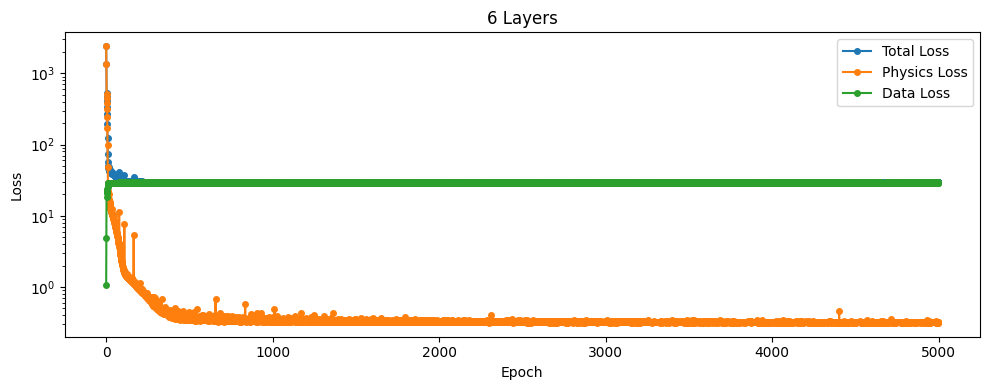

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.plot(loss_history, 'o-', markersize=4, label="Total Loss")
plt.plot(phys_history, 'o-', markersize=4, label="Physics Loss")
plt.plot(data_history, 'o-', markersize=4, label="Data Loss")

plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("6 Layers")

plt.tight_layout()
plt.legend()
plt.show()


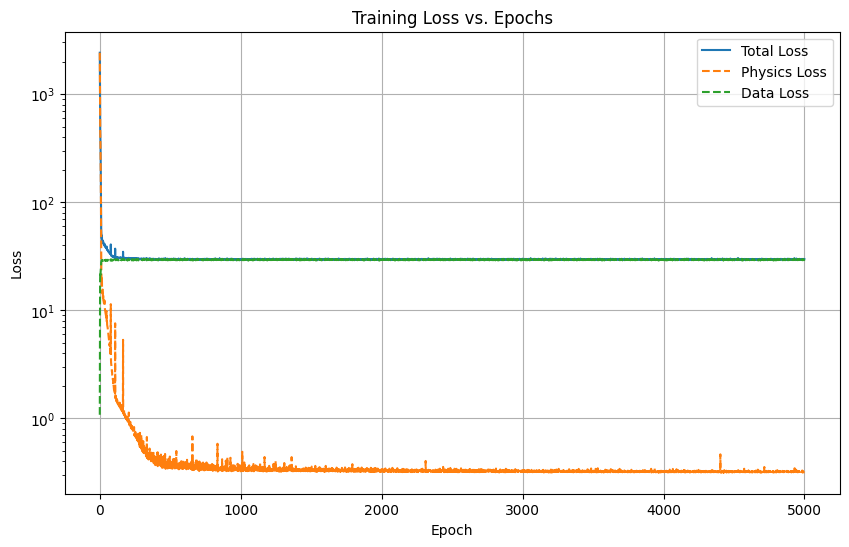

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label="Total Loss")
plt.plot(phys_history, label="Physics Loss", linestyle='--')
plt.plot(data_history, label="Data Loss", linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs. Epochs")
plt.legend()
plt.grid(True)
plt.yscale('log') # Use log scale for better visibility
plt.show()

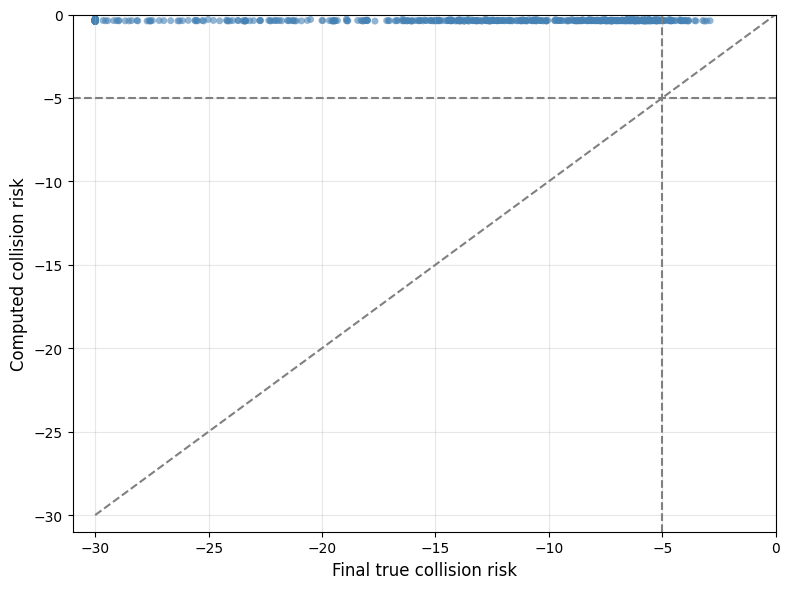

In [13]:

import matplotlib.pyplot as plt
import numpy as np

# Example input:
# Replace with your data:
# x = true collision risk
# y = predicted collision risk
x = P_test_true_denorm.numpy()
y = P_test_pred_denorm.numpy()

plt.figure(figsize=(8, 6))

# --- Main scatter plot ---
plt.scatter(x, y, s=25, alpha=0.6, color='steelblue', edgecolors='none')

# --- Dashed 45° line (perfect prediction) ---
min_val = min(x.min(), y.min())
max_val = max(x.max(), y.max())
plt.plot([min_val, max_val], [min_val, max_val], '--', color='gray')

# --- Vertical & horizontal dashed limits (matching your image) ---
plt.axvline(x=-5, linestyle='--', color='gray')
plt.axhline(y=-5, linestyle='--', color='gray')

# --- Axes labels ---
plt.xlabel("Final true collision risk", fontsize=12)
plt.ylabel("Computed collision risk", fontsize=12)

# --- Style, grid, and limits ---
plt.grid(True, alpha=0.3)
plt.xlim(min_val - 1, 0)
plt.ylim(min_val - 1, 0)

plt.tight_layout()
plt.show()
